# Откроем файл с данными и изучим общую информацию

In [1]:
import pandas as pd
df = pd.read_csv('/datasets/games.csv')

# посмотрим общую информацию
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [2]:
# Взглянем на данные
df

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [3]:
# Посмотрим список колонок (наличие лишних пробелов и тд)
print(df.columns)

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales',
       'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating'],
      dtype='object')


## Промежуточный вывод

- С названиями столбцов какая-то вакханалия, нужно посмотреть есть ли лишние пробелы и привести все к одному регистру
- Есть проблемы с типами
   1. Year_of_Release (float -> int)
   2. Critic_Score (float -> int) т.к. по данным не видно значений после нуля
   3. User_Score (string -> float)
- Возможно, понадобится выделение отдельных словарей для платформ, рейтинга, жанра
   - Для каждой категории нужно не забыть привести все к одному регистру перед поиском дубликатов
- Странное значение tbd в User_Score. Скорее всего оно означает to be done, т.е. можно считать, что в этих строках у нас нет данных пользовательского рейтинга
- Есть игры с почти нулевыми продажами обратим на них отдельное внимание

# Подготовим данные

In [4]:
# названия столбцов в целом нормальные, отражают суть содержащихся данных и не содержат других аномалий,
# кроме проблем с регистром, приведем их к одному виду
df.columns = [column.lower() for column in df.columns]
# проверим, что все ок
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [5]:
# Преобразуем данные в нужные типы

# Год не может быть вещественным числом
# Но т.к. есть null поля, мы нормально их не можем конвертировать
# Удалять эти данные пока не хочется, т.к. они могут пригодится для анализа данных, которые не относятся
# непосредственно к году, поэтому пока заполним их числом 0
# Для анализа данных по году эти данные в дальнейшем учитывать не будем

df['year_of_release'].fillna(0, inplace=True)
df['year_of_release'] = df['year_of_release'].astype('int')

# Перейдем к critic_score. Для начала убедимся, что нет значений отличных от нуля после запятой
# Не использую цикл for, т.к. на одном из вебинаров говорилось, что это не ок, поэтому создадим отдельный столбец
import math
def get_mantissa(value):
    if (math.isnan(value)):
        return 0
    
    return int(value % 1)

df['mantissa'] = df['critic_score'].apply(get_mantissa)
len(df.query('mantissa != 0'))

0

In [6]:
# т.к. дробной части у critic_score нет, удалим наш столбец
del df['mantissa']

## Ремарка

Прежде чем привести тип к int нам необходимо заполнить пропуски. В ходе исследования данных хорошо заметно, что чем меньше год, тем больше пропусков. Скорее всего отсутствие рейтинга означает либо

1. Игра слишком старая
2. Игра непопулярна
3. Игра еще не успела получить рейтинг в силу новизны
4. Прочие причины (не выгрузили и тд)

Это касается как рейтинга критиков, так и рейтинга пользователей.

Однако, рейтинг вещь крайне субъективная. Несмотря на то, что мода, медиана и среднее находятся в районе 70, есть большая вероятность переоценить плохие игры. Т.к. игры с реальным рейтингом 70+ вряд ли бы остались незамеченными или неоцененными.

**В связи с вышесказанным, мы поступим следующим образом.** 

1. Мы попробуем заполнить пропуски, но ориентируясь на медиану по двум параметрам - жанру и платформе, чтобы данные были более точными.
2. Мы создадим дополнительный столбец, в котором будет указано, меняли мы данные или нет (чтобы в дальнейшем при анализе мы могли отобрать только исходные "чистые" данные, если обнаружим проблемы, да и просто, чтобы сравнить выборки)

Однако, чтобы это сделать, сперва:
1. Разберемся с пропусками в жанре
2. Разберемся с пропусками в платформе
3. Проверим глазами наличие дубликатов и приведем при необходимости все к одному регистру

In [7]:
# Проверим дубликаты в платформе
df['platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [8]:
# Проверим дубликаты в жанре
df['platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [9]:
# Т.к. дубликатов нет, вернемся к пропускам. Пропуск у нас есть для жанров, посмотрим их
df[df['genre'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [10]:
# Т.к. полезного из этих данных мало, с чистой совестью их удалим
# Вместе с тем это решит вопрос с пустыми названиями
df.dropna(subset=['genre'], inplace=True)

## Избавимся от значений вида TBD

TBD, как правило, означает to be determined. Т.е. случай, когда рейтинг как бы есть, но как бы еще не до конца сформирован (возможно, сильно мало проголосовавших или мало времени прошло от начала голосования).

Для нас эти значения эквивалентны отсутствию значения для всех столбцов.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16713 non-null int64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(5), int64(1), object(5)
memory usage: 1.5+ MB


In [12]:
# уберем elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
# т.к. судя по ответу это бага, см. https://stackoverflow.com/questions/40659212/futurewarning-elementwise-comparison-failed-returning-scalar-but-in-the-futur
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# избавимся от значений вида tbd (to be determined)
df['user_score'] = df['user_score'].where(df['user_score'] != 'tbd')
df['critic_score'] = df['critic_score'].where(df['critic_score'] != 'tbd')
df['rating'] = df['rating'].where(df['rating'] != 'tbd')

In [13]:
# сохраним в отдельных столбцах исходные данные по рейтингам
# напомню, это чтобы мы могли в будущем получить выборку только по исходным данным при необходимости
df['critis_score_source'] = df['critic_score']
df['user_score_source'] = df['user_score']

In [14]:
# уберем RuntimeWarning: Mean of empty slice
# см. https://stackoverflow.com/questions/29688168/mean-nanmean-and-warning-mean-of-empty-slice
warnings.simplefilter("ignore", category=RuntimeWarning)

# напишем функцию, что поможет нам считать среднее по нашим параметрам (жанру и платформе)
def calc_score_by_genre_and_platform(df, genre, platform, field):
    # ориентируемся на оба параметра
    median = df[(df['genre'] == genre) & (df['platform'] == platform)][field].median()
    # но т.к. возможна уникальная ситуация, где нет совпадения для двух параметров, предусмотрим рассчет по 1му
    if math.isnan(median):
        median = df[df['genre'] == genre][field].median()
        if math.isnan(median):
            median = df[df['platform'] == platform][field].median()    
    return median

unique_genre = df['genre'].unique()
unique_platform = df['platform'].unique()
score_list = ['critic_score', 'user_score']

# идем по всем жанрам и платформам и заполняем для них пропуски (как для рейтинга критиков, так и пользователей)
for score_type in score_list:
    for genre in unique_genre:
        for platform in unique_platform:
            median = calc_score_by_genre_and_platform(df, genre, platform, score_type)
            searchRow = (df['genre'] == genre) & (df['platform'] == platform) & (df[score_type].isnull())
            df.loc[searchRow, score_type] = df.loc[searchRow, score_type].fillna(median)    

# изменим типы
df['critic_score'] = df['critic_score'].astype('int')
df['user_score'] = df['user_score'].astype('float')

# проверим, что все получилось
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 13 columns):
name                   16713 non-null object
platform               16713 non-null object
year_of_release        16713 non-null int64
genre                  16713 non-null object
na_sales               16713 non-null float64
eu_sales               16713 non-null float64
jp_sales               16713 non-null float64
other_sales            16713 non-null float64
critic_score           16713 non-null int64
user_score             16713 non-null float64
rating                 9949 non-null object
critis_score_source    8137 non-null float64
user_score_source      7590 non-null object
dtypes: float64(6), int64(2), object(5)
memory usage: 1.8+ MB


<a id="alteration1">**Разберемся с рейтингом**</a>

In [15]:
# Заполним пропущенные значения модой в зависимости от жанра
for genre in df['genre'].unique():
    mask = df['genre'] == genre
    mode = df.loc[mask, 'rating'].mode()[0]
    df.loc[mask, 'rating'] = df.loc[mask, 'rating'].fillna(mode)

In [16]:
# Проверим наличие дубликатов
df.duplicated().sum()

0

In [17]:
# сбросим индекс, т.к. данные мы все же удаляли
df = df.reset_index(drop=True)

In [18]:
# Посчитаем суммарные продажи во всех регионах
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
# посмотрим что получилось
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,critis_score_source,user_score_source,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,76.0,8,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,69,7.6,E,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,82.0,8.3,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,80.0,8,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,73,7.8,T,NaN,NaN,31.38


## Промежуточный вывод

- Мы обработали пропуски. В нашем случае, мы исходим из того, что рейтинг исправлять не нужно, но в качестве эксперимента для дальнейшего анализа мы оставили и исходные данные, и посчитанные через жанр и платформу, для большей точности.
- Привели типы к нужному виду
- Проверили наличие дубликатов
- Сразу посчитали общую сумму продаж по каждой игре

# Проведем исследовательский анализ данных

In [19]:
# Посмотрим сколько игр выпускалось в разные годы
df['year_of_release'].value_counts()

2008    1427
2009    1426
2010    1255
2007    1197
2011    1136
2006    1006
2005     939
2002     829
2003     775
2004     762
2012     653
2015     606
2014     581
2013     544
2016     502
2001     482
1998     379
2000     350
1999     338
1997     289
0        269
1996     263
1995     219
1994     121
1993      60
1981      46
1992      43
1991      41
1982      36
1986      21
1989      17
1983      17
1990      16
1987      16
1988      15
1985      14
1984      14
1980       9
Name: year_of_release, dtype: int64

**По большому счету, уже на данном этапе понятно, что нас будут интересовать данные, как минимум, после 1995 года, т.к. до этого не было существенного количества игр**

In [20]:
# Посмотрим, как менялись продажи по платформам. 

# Выберем платформы с наибольшими суммарными продажами 
top_platforms = df.groupby(['platform'])['total_sales'].sum().nlargest(10)
top_platforms

platform
PS2     1255.77
X360     971.42
PS3      939.65
Wii      907.51
DS       806.12
PS       730.86
GBA      317.85
PS4      314.14
PSP      294.05
PC       259.52
Name: total_sales, dtype: float64

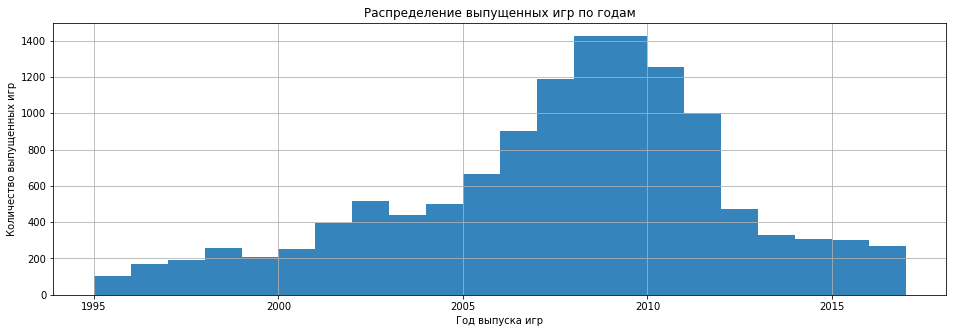

In [21]:
import matplotlib.pyplot as plt

# Построим распределение по годам. 
def make_bins(start, end, step):
    result = []
    for bin_elem in range(start, end + 1, step):
        result.append(bin_elem)
    return result

df_top_platforms = df.query('(platform in @top_platforms.index) and (year_of_release >= 1980)')

fig, ax = plt.subplots()
ax.set_title("Распределение выпущенных игр по годам")
ax.set_xlabel('Год выпуска игр')
ax.set_ylabel('Количество выпущенных игр')

df_top_platforms['year_of_release'].hist(bins=make_bins(1995, 2017, 1), figsize=(16,5), alpha=0.9, ax=ax)

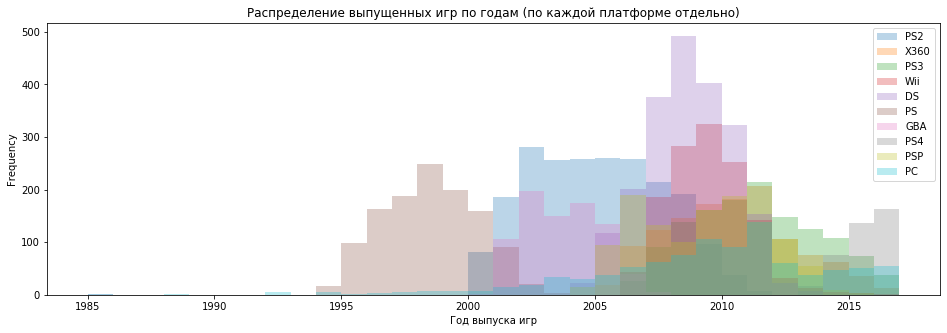

In [22]:
# Ответим на вопрос - за какой характерный срок появляются новые и исчезают старые платформы?

fig, ax = plt.subplots()
ax.set_title('Распределение выпущенных игр по годам (по каждой платформе отдельно)')
ax.set_xlabel('Год выпуска игр')
ax.set_ylabel('Количество выпущенных игр')

# Построим графики и посчитаем время жизни каждой платформы
mean_dict = dict()
for platform in top_platforms.index.tolist():
    df_platform = df_top_platforms.query('platform == @platform')
    
    min_year = df_platform['year_of_release'].min()
    max_year = df_platform['year_of_release'].max()
    
    mean_dict[platform] = max_year - min_year
    
    bins = make_bins(min_year, max_year+1, 1)
    df_platform['year_of_release'].plot(kind='hist',bins=bins, figsize=(16,5), alpha=0.3, ax=ax, legend=True)
    
ax.legend(top_platforms.index.tolist())

In [23]:
# Выведем полученные значения
mean_dict

{'PS2': 11,
 'X360': 11,
 'PS3': 10,
 'Wii': 10,
 'DS': 28,
 'PS': 9,
 'GBA': 7,
 'PS4': 3,
 'PSP': 11,
 'PC': 31}

In [24]:
# Хотя у нас есть явные любопытные значения, в виде 3х лет и 31 года, посчитаем среднее вместе с ними
mean = sum(mean_dict.values()) / len(mean_dict.values())
mean

13.1

In [25]:
# Посчитаем среднее без nintendo, PC, PS4
# PS4 недавно появилось на рынке поэтому будет влиять на общую картину, а DS и PC - старожилы, что никак не умирают
# Будем держать это в голове, но по общей картине данные платформы скорее исключение из правил
# Чтобы получить среднее по платформам, более приближенное к реальности, посчитаем без них
del mean_dict['PC']
del mean_dict['DS']
del mean_dict['PS4']

mean = sum(mean_dict.values()) / len(mean_dict.values())
mean

9.857142857142858

**Таким образом, среднее время жизни одной платформы будем считать за 10 лет. Хотя есть нюансы в виде PC, который жил, жив и (вероятно) будет жить.**

In [26]:
# Возьмем только актуальные данные и в дальнейшем будем работать только с ними
# Актуальными будем считать данные с года выпуска - после 1995 (обрежем по основному датафрэйму)
# При этом для основных рассчетов, мы будем использовать срез за последние 10 лет (это самые актуальные данные)
df = df.query('(year_of_release >= 1995)')
df_actual = df.query('(year_of_release >= 2014)')

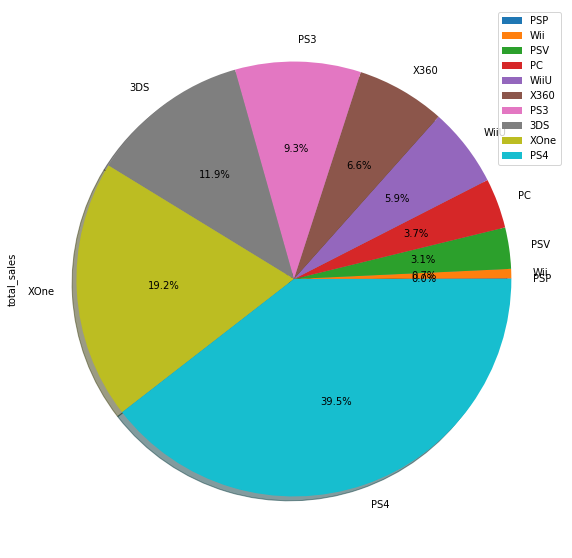

In [27]:
# попробуем более короткий срез
df_actual_1 = df.query('year_of_release >= 2014')
df_platform_pivot_1 = df_actual_1.groupby('platform')['total_sales'].agg('sum').sort_values(ascending = True)
#df_platform_pivot_1
df_platform_pivot_1.plot.pie(figsize=(10, 10), autopct='%1.1f%%',shadow = True)
# расположение легенды
plt.legend()
plt.show()

**Небольшая ремарка**

Таким образом мы отрезали хвост. Но поскольку платформы живут последние 10 лет, выбирать стоит именно из 10 летнего периода. Но отрезание данных на данном этапе может не позволить нам посмотреть на закономерности в других параметрах (например, жанру)

Поэтому держим это в голове, возможно в будущем обратимся к полному срезу.

In [28]:
# Выберем потенциально прибыльные платформы. Это явно платформы, которые существуют менее 10 лет
# и которые показывают рост за последний период, для этого построим график

# сгруппируем данные
df_platform_pivot = df_actual.pivot_table(index=['platform', 'year_of_release'], values=['total_sales'], aggfunc=['sum'])
df_platform_pivot = df_platform_pivot.reset_index(level='year_of_release')
df_platform_pivot.columns = ['year', 'total_sales_sum']

# переформируем данные, чтобы вывести на одном графике все с красивыми легендами без циклов и тд
df_platform_pivot_for_plot = df_platform_pivot.reset_index()
df_platform_pivot_for_plot = df_platform_pivot_for_plot.pivot(index='year', columns='platform', values='total_sales_sum')

<a id='warning1'>Выведем графики</a>

Text(0, 0.5, 'Сумма продаж')

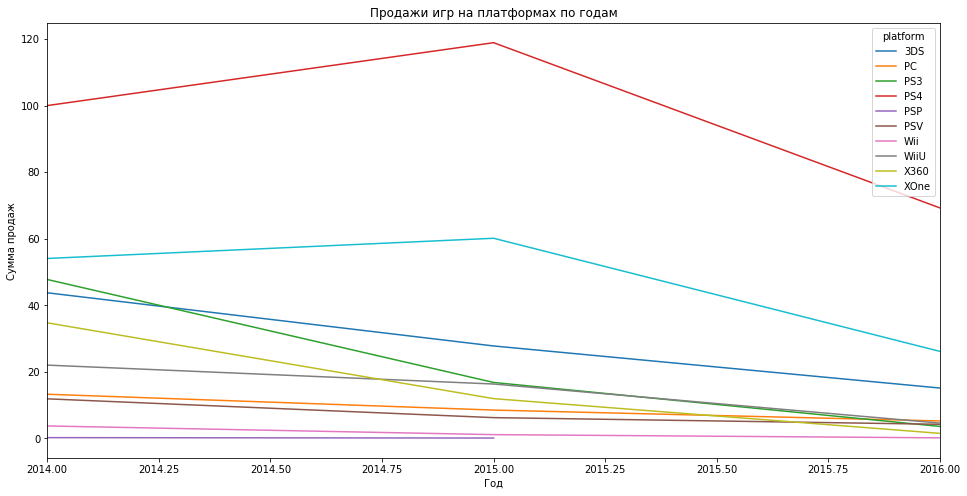

In [29]:
# выведем графики
fig, ax = plt.subplots()
df_platform_pivot_for_plot.plot(figsize=(16,8), ax=ax)
ax.set_title('Продажи игр на платформах по годам')
ax.set_xlabel('Год')
ax.set_ylabel('Сумма продаж')

#### Промежуточный вывод

Большинство платформ к этому времени, увы, умерло. Наибольший интерес представляют три платформы:
1. PS4
2. XBox One
3. PC

Т.к. данные за 2016 год неполные, скорее всего дальше они покажут еще больший рост. PS4 лидирует, демонстрируя огромный рост. XBox one также показывает рост (помним, что данные за 2016 м.б. не полными)
PC актуален т.к. платформа живет на протяжении 20 лет, хотя и не может похвастаться такими цифрами продаж.

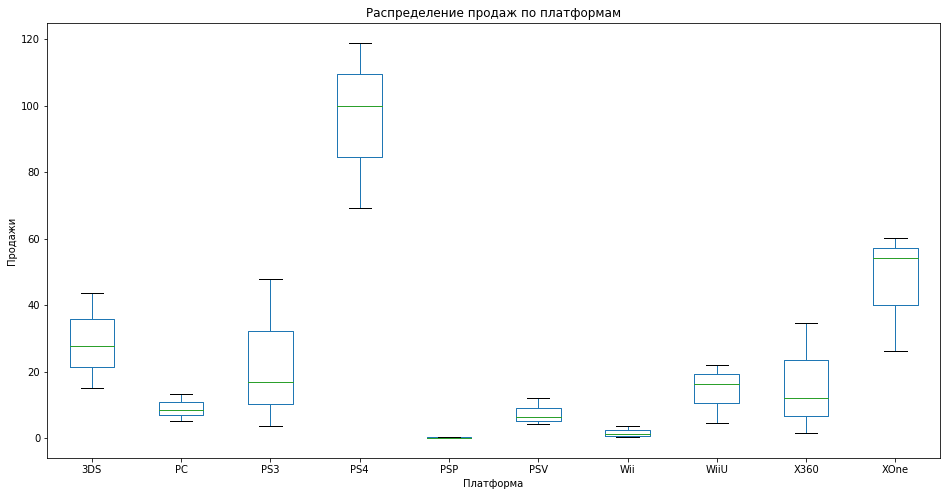

In [30]:
# Построим boxplot

# Чтобы избавиться от ворнинга, нужно построить отдельные графики или заменить пропущенные значения на 0
# примерно так - df_platform_pivot_for_plot.fillna(0, inplace=True)
# но это влияет на итоговые выводы, поэтому пока живем с ним

# построим график
df_platform_pivot_for_plot.fillna(0, inplace=True)

fig, ax = plt.subplots(1)
ax.set_title('Распределение продаж по платформам')
ax.set_xlabel('Платформа')
ax.set_ylabel('Продажи')
df_platform_pivot_for_plot.plot(kind='box', figsize=(16,8), ax=ax)

**Промежуточный вывод**

Видно, что платформы сильно отличаются друг от друга. В некотором смысле, чем платформа популярнее, тем больше разброс ее значений. При этом графики действительно сильно разные. Хорошо выделяются консоли PS2, PS3, PS4 и X360.

Вместе с этим, Nintendo DS отстает, но не сильно.

При этом различия касаются как продаж в целом, так и их средних значений.
Непопулярные платформы не сильно далеко ушли от линии нуля. Впрочем, как и новые для нас платформы.

Однако, при этом не понятно, как обстоят дела с PC - несмотря на небольшой разброс, за 20 лет, как игровая платформа он обладает завидным постоянством. При этом до показателей консолей ему действительно далеко.

**UPD: После смены актуального периода выводы не поменялись, но более явно видно, что XOne и PS4 сильно выделяются на фоне остальных платформ**

Text(0, 0.5, 'Сумма продаж')

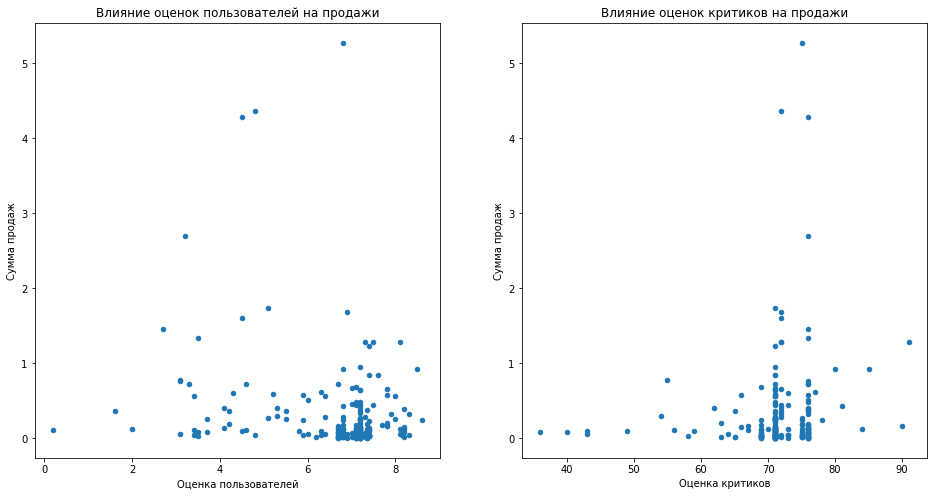

In [31]:
# Посмотри на влияние на продажи отзывов пользователей и критиков
# Возьмем за основу данные по PS3, как популярной платформы с длинным временем жизни
df_ps3 = df_actual.query('platform == "PS3"')

# Построим диаграмму рассеяния

fig, ax = plt.subplots(1, 2)
df_ps3.plot(x='user_score', y='total_sales', kind='scatter', ax=ax[0], figsize=(16,8))
df_ps3.plot(x='critic_score', y='total_sales', kind='scatter', ax=ax[1], figsize=(16,8))

ax[0].set_title('Влияние оценок пользователей на продажи')
ax[0].set_xlabel('Оценка пользователей')
ax[0].set_ylabel('Сумма продаж')
ax[1].set_title('Влияние оценок критиков на продажи')
ax[1].set_xlabel('Оценка критиков')
ax[1].set_ylabel('Сумма продаж')

In [32]:
# Посчитаем корреляцию между отзывами и продажами
df_ps3[['user_score', 'critic_score', 'total_sales']].corr()

,user_score,critic_score,total_sales
user_score,1.000000,0.217795,-0.228347
critic_score,0.217795,1.000000,0.136931
total_sales,-0.228347,0.136931,1.000000


In [33]:
# посмотрим для остальных платформ

df_slice = df_actual.query('platform in @top_platforms.index')[['platform', 'user_score', 'critic_score', 'total_sales']]

df_result = pd.DataFrame(data=[], index=['user_score', 'critic_score'], columns=[])
for platform in df['platform'].unique():
    df_slice_platform = df_slice.query('platform == @platform')
    user_score_corr = df_slice_platform['user_score'].corr(df_slice_platform['total_sales'])
    critic_score_corr = df_slice_platform['critic_score'].corr(df_slice_platform['total_sales'])
    df_result[platform] = [user_score_corr, critic_score_corr]

df_result.dropna(axis='columns', inplace=True)
# посмотрим, что получилось
df_result

,Wii,X360,PS3,PS4,PC,PSP
user_score,0.298655,-0.170145,-0.228347,-0.075062,-0.101989,-0.165326
critic_score,0.333500,0.252686,0.136931,0.332423,0.154245,0.382990


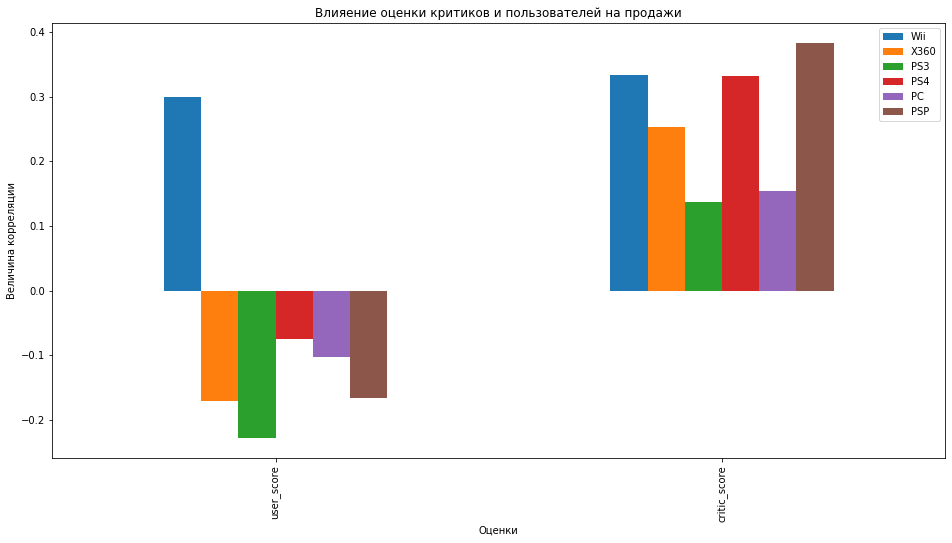

In [34]:
# Построим график для наглядного сравнения
fig, ax = plt.subplots(1)
ax.set_title('Влияение оценки критиков и пользователей на продажи')
ax.set_xlabel('Оценки')
ax.set_ylabel('Величина корреляции')
df_result.plot(kind='bar', figsize=(16,8), ax=ax)

**Промежуточный вывод**

- Рейтинг критиков явно сильнее влияет на продажи, чем рейтинг пользователей
- При это рейтинг критиков больше 70 начинает оказывать ощутимое влияние, в диапазоне от 40 до 70 рост не такой большой
- Есть игры, которые хорошо продаются, невзирая на пользовательский рейтинг. Вероятно это связано с тем, что пользовательский рейтинг не всегда объективен, т.к. игроки могут начать занижать рейтинг игре по причинам, непосредственно с игрой не связанным (сексизм, феминизм, сказаное лишнее слово в интервью и тд).
- Очень любопытная ситуация с GBA, когда, чем хуже оценки, тем выше продажи. Возможно это связано с низким качеством игр и низким качеством ассортимента для этой платформы. Либо несовпадением ожиданий.
- В целом, общая тенденция для любой платформы схожа - оценки игроков имеют крайне слабую корреляцию, а вот оценки критиков - более ощутимую. Чем выше оценка - тем больше продажи.

In [35]:
# Посмотрим на распределение игр по жанрам
df_actual['genre'].value_counts()

Action          619
Role-Playing    221
Adventure       185
Sports          161
Shooter         128
Misc            113
Racing           69
Fighting         60
Simulation       44
Platform         38
Strategy         37
Puzzle           14
Name: genre, dtype: int64

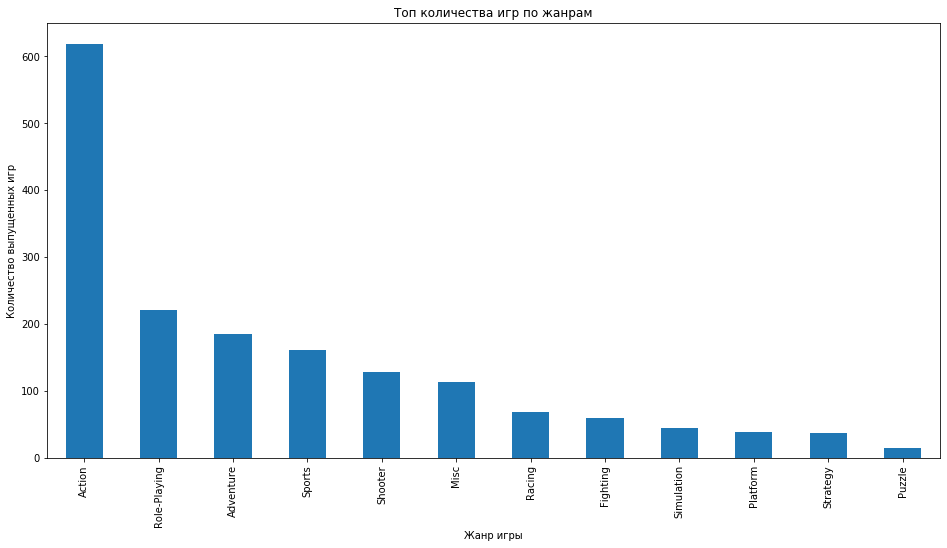

In [36]:
# Построим график для наглядности
fig, ax = plt.subplots(1)
ax.set_title('Топ количества игр по жанрам')
ax.set_xlabel('Жанр игры')
ax.set_ylabel('Количество выпущенных игр')
df_actual['genre'].value_counts().plot(kind='bar', figsize=(16,8), ax=ax)

In [37]:
# посмотрим средние данные по продажам по каждому жанру
top_genre_sales = df_actual.groupby('genre')['total_sales'].mean().nlargest(15)
top_genre_sales

genre
Shooter         1.335469
Sports          0.680000
Platform        0.476053
Fighting        0.470333
Role-Playing    0.459005
Racing          0.398841
Misc            0.332301
Action          0.322068
Simulation      0.298409
Puzzle          0.157857
Strategy        0.107027
Adventure       0.094865
Name: total_sales, dtype: float64

In [38]:
# для сравнения посмотрим данные по продажам для платформы PS3
top_ps3_genre_sales = df_ps3.groupby('genre')['total_sales'].mean().nlargest(15)
top_ps3_genre_sales

genre
Shooter         0.869286
Sports          0.529394
Misc            0.477857
Platform        0.253333
Role-Playing    0.236786
Action          0.235065
Simulation      0.195000
Fighting        0.170000
Racing          0.125000
Adventure       0.094286
Strategy        0.060000
Puzzle          0.040000
Name: total_sales, dtype: float64

Text(0, 0.5, 'Сумма продаж')

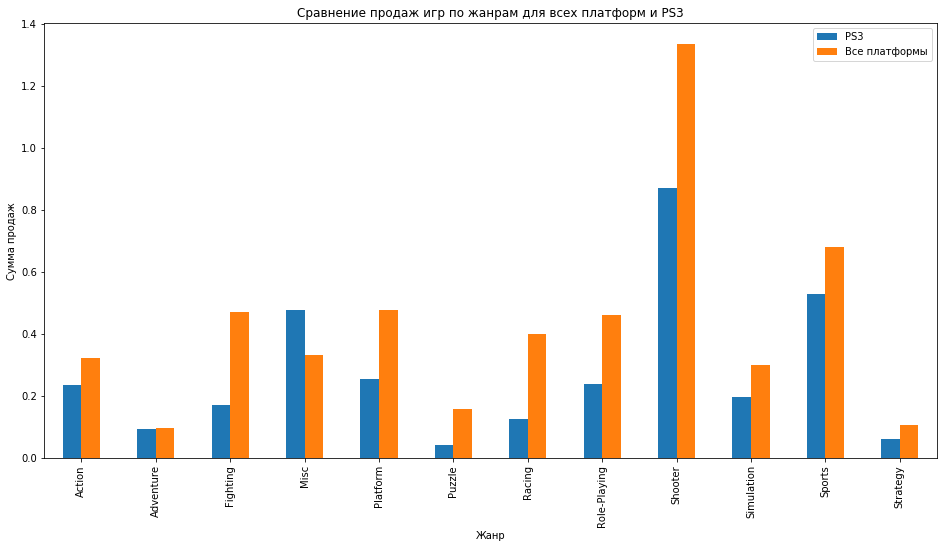

In [39]:
# построим графики

df_for_plot = pd.DataFrame({'PS3': top_ps3_genre_sales, 'Все платформы':top_genre_sales})
ax = plt.subplot()
df_for_plot.plot(kind='bar', figsize=(16,8), ax=ax)
ax.set_title('Сравнение продаж игр по жанрам для всех платформ и PS3')
ax.set_xlabel('Жанр')
ax.set_ylabel('Сумма продаж')

**Промежуточный вывод**

- Самыми прибыльными жанрами являются шутеры, платформеры, спортивные игры
- Несмотря на то, что первое место по количеству игр занимает Action и имеет в целом неплохие показатели продаж, они не занимают лидирующие позиции в этом направлении
- Приключенческие игры, которых выпускается много, имеют одни их худших показателей продаж. Скорее всего это связано с тем, что люди ищут что-то более казуальное для отдыха после работы
- Ролевые игры занимают золотую середину вместе с играми смешанных жанров, хотя выпускаются в большом количестве

# Составим портрет пользователя каждого региона

Text(0, 0.5, 'Количество игр')

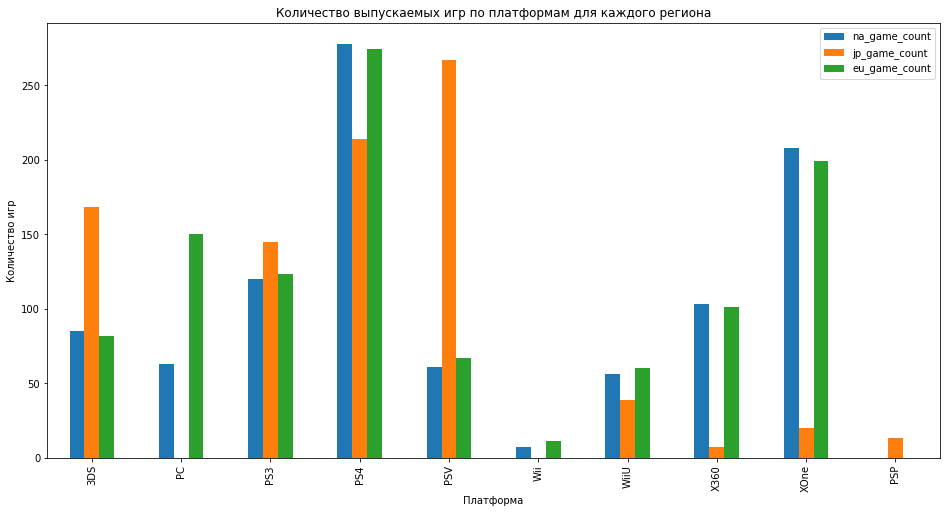

In [40]:
# сначала определим df с которыми будем работать
df_na = df_actual.query('na_sales > 0')
df_jp = df_actual.query('jp_sales > 0')
df_eu = df_actual.query('eu_sales > 0')

# посчитаем количество игр по каждой платформе
df_na_count = df_na.groupby('platform')['name'].count().to_frame()
df_na_count.columns = ['na_game_count']
df_jp_count = df_jp.groupby('platform')['name'].count().to_frame()
df_jp_count.columns = ['jp_game_count']
df_eu_count = df_eu.groupby('platform')['name'].count().to_frame()
df_eu_count.columns = ['eu_game_count']

# составим DF, объеденив данные, чтобы вывести на одном графике
df_for_bar = df_na_count.merge(df_jp_count, how='outer', on='platform')
df_for_bar = df_for_bar.merge(df_eu_count, how='outer', on='platform')

del df_na_count
del df_jp_count
del df_eu_count

# выведем график
fig, ax = plt.subplots(1)
df_for_bar.plot(kind='bar', figsize=(16,8), ax=ax)
ax.set_title('Количество выпускаемых игр по платформам для каждого региона')
ax.set_xlabel('Платформа')
ax.set_ylabel('Количество игр')

Text(0, 0.5, 'Сумма продаж')

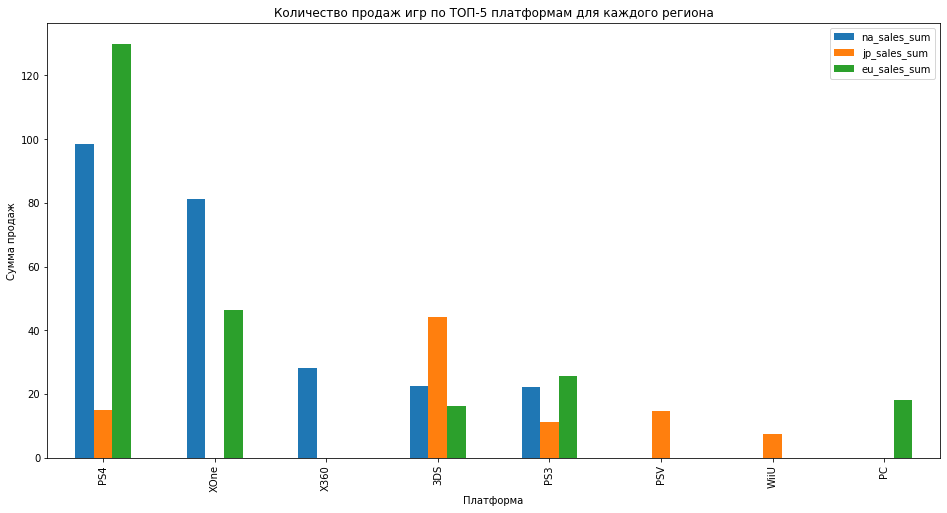

In [41]:
# посмотрим сумму продаж по каждой платформе и возьмем топ-5 платформ

# попробуем написать функцию, для создания DF для графика
def make_df_for_bar(groupby_value, type_value, func_value, top_count):
    regions = ['na', 'jp', 'eu']
    for region in regions:
        if (type_value == 'sales'):
            column_name = region + '_' + type_value
        else:
            column_name = type_value
        
        if region == 'na':
            df_na_temp = df_na.groupby(groupby_value)[column_name]
        elif region == 'jp':
            df_jp_temp = df_jp.groupby(groupby_value)[column_name]
        else:
            df_eu_temp = df_eu.groupby(groupby_value)[column_name]
    
    if (func_value == 'sum'):
        df_na_temp = df_na_temp.sum().nlargest(top_count).to_frame()
        df_jp_temp = df_jp_temp.sum().nlargest(top_count).to_frame()
        df_eu_temp = df_eu_temp.sum().nlargest(top_count).to_frame()
    else:
        df_na_temp = df_na_temp.count().nlargest(top_count).to_frame()
        df_jp_temp = df_jp_temp.count().nlargest(top_count).to_frame()
        df_eu_temp = df_eu_temp.count().nlargest(top_count).to_frame()
        
    df_na_temp.columns = ['na_' + type_value + '_' + func_value]
    df_jp_temp.columns = ['jp_' + type_value + '_' + func_value]
    df_eu_temp.columns = ['eu_' + type_value + '_' + func_value]
    
    result = df_na_temp.merge(df_jp_temp, how='outer', on=groupby_value)
    result = result.merge(df_eu_temp, how='outer', on=groupby_value)
    
    return result

df_for_bar = make_df_for_bar('platform', 'sales', 'sum', 5)

# выведем график
fig, ax = plt.subplots(1)
df_for_bar.plot(kind='bar', figsize=(16,8), ax=ax)
ax.set_title('Количество продаж игр по ТОП-5 платформам для каждого региона')
ax.set_xlabel('Платформа')
ax.set_ylabel('Сумма продаж')

**Промежуточный вывод**

- Северная америка приносит больше всего прибыли, а вот Япония приносит меньше всего денег
- В Северной Америке по сумме продаж лидирует X360, в Японии нинтендо, а в Европе PS3
- В Японии немного отличается топ продаж от Европы и Америки - они включают 3DS и PSP, которые не находятся в топе остальных регионов
- В США попал в топ PS2, несмотря на наличие PS3. Скорее всего есть определенная любовь к играм прошлого
- А в Европе - PS4. Можно считать ее более прогрессивной (все же платформа новая) и консервативной (в топе нет каких-то специфичных платформ)
- При этом по покупаемым играм во всех регионах лидирует Нинтендо и PS3. Суммируя остальное, PS3 получается наиболее универсальной платформой для всех регионов

Text(0, 0.5, 'Сумма продаж')

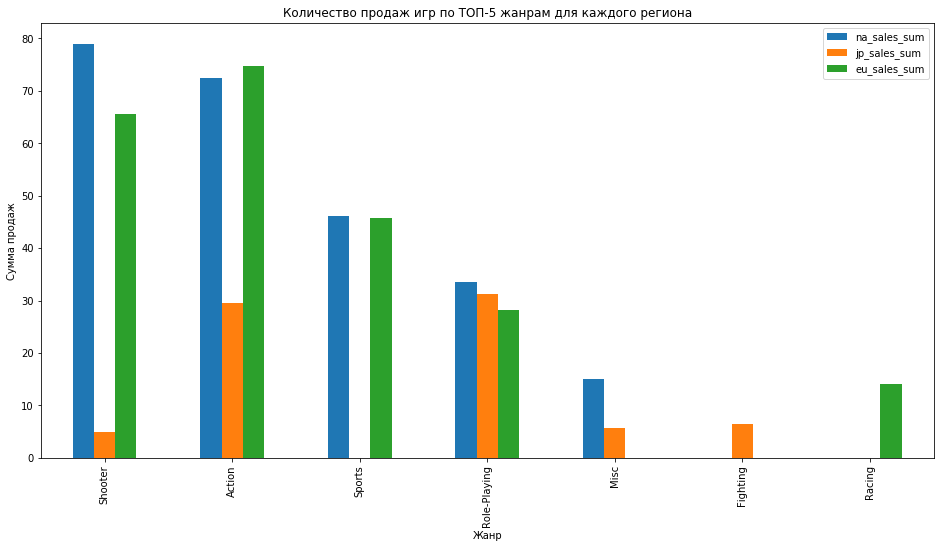

In [42]:
# Посмотрим на распределение популярных жанров (топ-5) по деньгам
df_for_bar = make_df_for_bar('genre', 'sales', 'sum', 5)

fig, ax = plt.subplots(1)
df_for_bar.plot(kind='bar', figsize=(16,8), ax=ax)
ax.set_title('Количество продаж игр по ТОП-5 жанрам для каждого региона')
ax.set_xlabel('Жанр')
ax.set_ylabel('Сумма продаж')

Text(0, 0.5, 'Количество выпущенных игр')

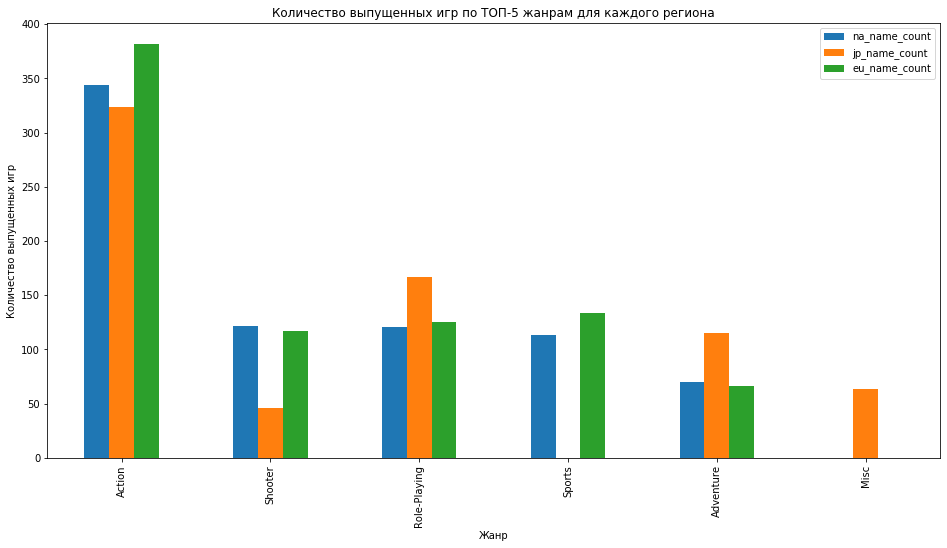

In [43]:
# Посмотрим на распределение популярных жанров (топ-5) по количеству продаваемых игр
df_for_bar = make_df_for_bar('genre', 'name', 'count', 5)

# построим график
fig, ax = plt.subplots(1)
df_for_bar.plot(kind='bar', figsize=(16,8), ax=ax)
ax.set_title('Количество выпущенных игр по ТОП-5 жанрам для каждого региона')
ax.set_xlabel('Жанр')
ax.set_ylabel('Количество выпущенных игр')

**Промежуточный вывод**

- В Японии больше всего ценят ролевые игры
- Предпочтения в Америке и Европе, в целом, схожи
- В целом, самым популярным жанром для любого региона можно считать Action
- Спортивные игры и шутеры не отстают, но, что любопытно, Япония опять выделяется - там шутеры ценят не особо. Возможно, это как-то связано с местным законодательством.
- И в той же Японии ценят приключенческие игры, которые получили третье место, но не попали в топ Америки и Европы

In [44]:
# Посмотрим, влияет ли рейтинг ESRB на продажи в отдельном регионе
pd.options.mode.chained_assignment = None

def rating_to_number(value):
    rating_dict = dict()
    rating_dict['EC'] = 0
    rating_dict['E'] = 1
    rating_dict['E10+'] = 2
    rating_dict['T'] = 3
    rating_dict['M'] = 4
    rating_dict['RP'] = 5
    
    return rating_dict[value]

df_actual.reset_index(inplace=True)
df_actual['rating_category'] = df_actual['rating'].apply(rating_to_number)

# RP означает "в ожидании рейтинга". Такие игры нам не помогут, уберем их
df_actual_not_rp = df_actual.query('rating != "RP"')
df_actual_not_rp = df_actual_not_rp[['na_sales', 'jp_sales', 'eu_sales', 'rating_category']]

In [45]:
# Выведем матрицу корреляции
df_actual_not_rp.corr()

,na_sales,jp_sales,eu_sales,rating_category
na_sales,1.000000,0.264362,0.735920,0.132351
jp_sales,0.264362,1.000000,0.188675,0.037620
eu_sales,0.735920,0.188675,1.000000,0.091044
rating_category,0.132351,0.037620,0.091044,1.000000


**Промежуточный вывод**

Поскольку мы присваивали числовые значения рейтингу не просто так, а исходили из того, что чем число выше, тем рейтинг старше, то можно сказать следующее:

1. Для Северной Америки и Европы чуть лучше продаются игры с более старшим рейтингом. Но эта корреляция не так сильно выражена, как в случае с Японией
2. А вот в Японии рейтинг имеет огромное значение и гораздо лучше продаются игры с более "детским" рейтингом. Наглядное представление в разнице менталитетов.

# Проверим гипотезы

## Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Для начала сформулируем гипотезы H0 и H1.

- **Гипотеза H0**: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые (т.е. игры получает примерно равные оценки)
- **Гипотеза H1**: Средние пользовательские рейтинги платформ Xbox One и PC различаются (т.е. игры в среднем получают разные оценки)

Сформулируем это в коде

In [46]:
from scipy import stats as st

# Перенесем гипотезы в код
H0 = 'Не можем отвергнуть гипотизу - средние пользовательские рейтинги платформ Xbox One и PC одинаковы'
H1 = 'Отвергаем нулевую гипотезу, средние пользовательские рейтинги платформ Xbox One и PC различаются'

# Зададим критический уровень статистической значимости в 5%
# Почему именно в 5 - как одно из широко применяемых значений, точность в 1% в наших вопросах нам не нужна
alpha = 0.05 

# Подготовим выборки
df_xbox_one = df_actual.query('platform == "XOne"')
df_pc = df_actual.query('platform == "PC"')

<a id="alteration2">Убедимся, что мы можем использовать Т-криттерий стьюдента</a>

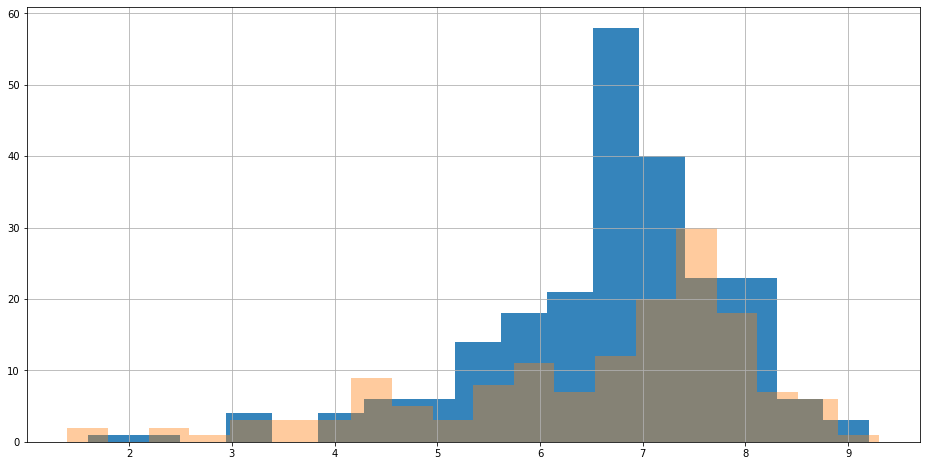

In [47]:
# Посмотрим на распределение оценок
df_xbox_one['user_score'].hist(bins=17, alpha=0.9, figsize=(16,8))
df_pc['user_score'].hist(bins=20, alpha=0.4, figsize=(16,8))

In [48]:
# Посмотрим на общее количество данных
print('PC count =', df_pc['user_score'].count())
print('Xbox count =', df_xbox_one['user_score'].count())

PC count = 151
Xbox count = 228


<a id="notice1">Ремарка</a>

В нашем случае мы имеем количественные данные в двух независимых группах, которые распределены нормально. При этом наши выборки не сверхмалы и не содержат явных выбросов. Поэтому Т-криттерий Стьюдента нам подходит для использования.

In [49]:
# equal_var = False, т.к. различаются дисперсии выборок
results = st.ttest_ind(df_xbox_one['user_score'], df_pc['user_score'], equal_var = False)

if results.pvalue < alpha:
    print(H1)
else:
    print(H0)

Не можем отвергнуть гипотизу - средние пользовательские рейтинги платформ Xbox One и PC одинаковы


In [50]:
# Ради интереса посмотрим какие вообще средние оценки
print('XBOX user score mean = ', df_xbox_one['user_score'].mean())
print('PC user score mean = ', df_pc['user_score'].mean())

XBOX user score mean =  6.6798245614035086
PC user score mean =  6.535761589403973


## Средние пользовательские рейтинги жанров Action и Sports разные

Для начала сформулируем гипотезы H0 и H1.

- **Гипотеза H0**: Средние пользовательские рейтинги жанров Action и Sports одинаковы (т.е. жанры получают примерно равные оценки)
- **Гипотеза H1**: Средние пользовательские рейтинги жанров Action и Sports различаются (т.е. данные жанры в среднем получают разные оценки)

In [51]:
# Перенесем гипотезы в код
H0 = 'Не можем отвергнуть гипотизу - cредние пользовательские рейтинги жанров Action и Sports одинаковы'
H1 = 'Отвергаем нулевую гипотезу, cредние пользовательские рейтинги жанров Action и Sports различаются'

# Подготовим выборки
df_action = df_actual.query('genre == "Action"')
df_sports = df_actual.query('genre == "Sports"')

<a id="alteration3">Также проверим распределение величин</a>

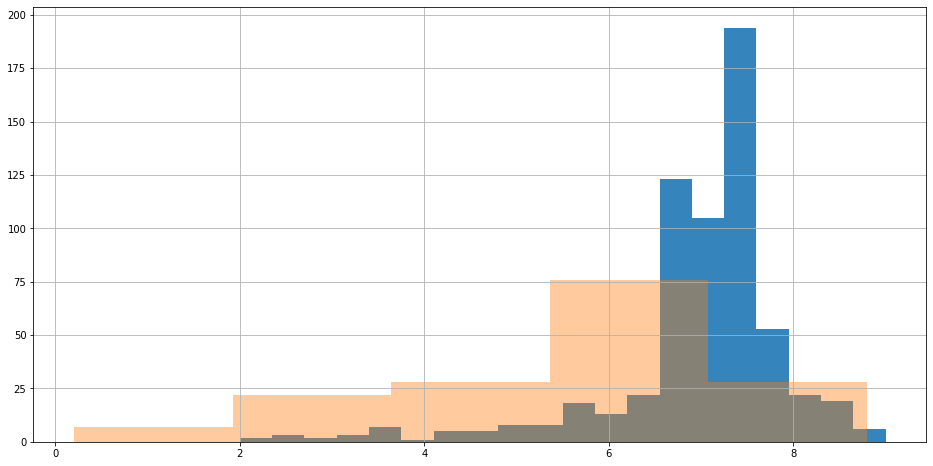

In [52]:
# Посмотрим на распределение оценок
df_action['user_score'].hist(bins=20, alpha=0.9, figsize=(16,8))
df_sports['user_score'].hist(bins=5, alpha=0.4, figsize=(16,8))

In [53]:
# Посмотрим на общее количество данных
print('PC count =', df_action['user_score'].count())
print('Xbox count =', df_sports['user_score'].count())

PC count = 619
Xbox count = 161


По <a href="#notice1">аналогичной логике</a>, используем Т-криттерий стьюдента

In [54]:
# equal_var = true, т.к. совокупности по параметрам не различаются
# критический уровень не переопределяем, оставим также 5 процентов
results = st.ttest_ind(df_action['user_score'], df_sports['user_score'], equal_var = False)

if results.pvalue < alpha:
    print(H1)
else:
    print(H0)

Отвергаем нулевую гипотезу, cредние пользовательские рейтинги жанров Action и Sports различаются


In [55]:
# Ради интереса посмотрим какие вообще средние оценки
print('Action user score mean = ', df_action['user_score'].mean())
print('Sports user score mean = ', df_sports['user_score'].mean())

Action user score mean =  6.969951534733441
Sports user score mean =  5.516149068322982


# Общий вывод

Мы провели хорошую работу, чтобы выявить закономерности, определяющий успех наших игр.

**Для этого мы**
1. Изучили наши данные. И хочется сказать спасибо человеку, выгружающему данные, в этом проекте набор не содержал каких-то критичных ошибок.
2. Провели небольшую их подготовку, заполнили недостающие значения, удалили дубликаты и избавились от ненужных значений (TBD)
3. Провели небольшое исследование наших данных
   1. Выяснили, что средний срок жизни платформы 10 лет и нас интересуют данные не раньше 2006го года
   2. Выделили три платформы, на которые стоит отдельно обратить внимание - PS4, Xbox One, PC
   3. Обратили внимание, что в целом за весь период хорошо себя показывают консоли семейста PS (2, 3, 4)
   4. Обнаружили, что оценки критиков оказывают более весомое влияние на продажи, чем оценки пользователей
   5. Выяснили, что самыми прибыльными жанрами являются шутеры, платформеры, спортивные игры
4. Отдельно исследовали предпочтения каждого из трех представленных регионов (Северной Америки, Европы и Японии)
   1. Обнаружили, что самым прибыльным регионом является Северная Америка, а Япония приносит меньше всего денег
   2. При этом в каждом регионе свои лидеры среди платформ по продажам
      - В Северной Америке это X360
      - В Японии - Nintendo DS
      - В Европе - PS3
   3. Самой прогрессивной по отношению к новым платформам можно считать Европу
   4. Наиболее универсальной платформой для всех является PS3
   5. Также, мы увидели, что предпочтения в самих играх у Европы и Америки, в целом, схожи, а вот в Японии явно выделяется любовь к ролевым и приключенческим играм. 
   6. И шутеры в Японии ценятся не особо, хотя очень любят в Европе и Америке
   7. Общим по популярности жанром для каждого региона можно считать Action
   8. Также мы обнаружили, что в Японии более консервативны в выборе игр и предпочитают игры с менее взрослым рейтингом, в то время как в Европе и Америке, чуть больше предпочтения отдается играм со взрослым рейтингом.
5. Кроме этого, мы проверили наши гипотезы и выяснили, что
   1. Средние пользовательские рейтинги платформ Xbox One и PC различаются
   2. Также как и cредние пользовательские рейтинги жанров Action и Sports различаются

**Возвращаясь к общему итогу**

Целью нашего исследования было выявление закономерностей, определяющих успех игр, что в дальнейшем будет использоваться при планировании рекламных кампаний.

Исходя из нашего исследования, стоит сделать ставку на:
1. Игры жанра шутеры, платформеры и спортивные игры. Также стоит обратить внимание на жанр Action как наиболее универсальный для всех регионов
2. Больше всего денег тратят на игры жители Северной Америке - поэтому в целом, стоит ориентироваться на этот рынок, как наиболее прибыльный. 
   - Однако стоит не забывать, что общие предпочтения схожи с Европой, поэтому рекламные кампании для этих двух регионов могут быть схожи. Т.е. можно попытаться сразу задействовать оба рынка.
3. Япония слишком специфичный рынок, со своими предпочтениями, приносящий мало денег на общем фоне. Возможно, стоит исключить его из рекламных кампаний.
4. Если говорить про платформу, на которую делать ставку в ближайшее время, то это явно **PS4**, т.к. она показывает хороший рост и вышла относительно недавно. К тому же, ее предшественники PS2 и PS3 продемонстрировали отличный финансовый результат и лидерство.
   - Кроме того, не следует забывать, что в Северной Америке предпочитают X360, а значит потенциально там может чуть лучше выстрелить XOne. Т.е. если ориентироваться именно на рынок Америки, стоит сделать акцент сразу на две платформы - XOne и PS4.
   - PC и Nintendo показывают хорошие сроки жизни, но низкую прибыль. Однако за их постоянство, стоит также выделить им определенный рекламный бюджет для страховки (чтобы не класть все яйца в одну корзину)
   - Оставшиеся платформы или не приносят столько денег, или уже отживают свой срок жизни
